# Working with existing deployments

In [1]:
from skil import Skil, Service
from skil import get_workspace_by_id
from skil import get_experiment_by_id
from skil import get_model_by_id
from skil import get_deployment_by_id

skil_server = Skil(
    host      = 'localhost',
    port      = 9008,
    user_id   = 'admin',
    password  = 'Skymind'
)

Using TensorFlow backend.


'>>> Authenticating SKIL...'
'>>> Done!'


In [14]:
model_history_server_id = 'a547a15d-5be7-33a1-8b6b-5147e1fd7283'

skil_server.api.list_all_experiments(model_history_server_id)

[{'best_model_id': None,
  'experiment_description': 'experiment',
  'experiment_id': 'yolo-experiment-01',
  'experiment_name': 'yolo-experiment',
  'input_data_uri': None,
  'last_updated': None,
  'model_history_id': 'c1025186-e71d-4706-a49b-51b7aab59900',
  'notebook_json': None,
  'notebook_url': None,
  'zeppelin_id': None}]

In [15]:
model_history_id = 'c1025186-e71d-4706-a49b-51b7aab59900'

skil_server.api.get_model_history(model_history_server_id, model_history_id)

{'created': 1557320344000,
 'model_history_id': 'c1025186-e71d-4706-a49b-51b7aab59900',
 'model_labels': None,
 'model_name': 'yolo-workspace'}

## Get deployment

In [16]:
workspace_id  = model_history_id
experiment_id = 'yolo-experiment-01'
model_id      = 'yolo-model-01'
deployment_id = '0'

work_space = get_workspace_by_id(skil_server, workspace_id)

experiment = get_experiment_by_id(work_space, experiment_id)

deployment = get_deployment_by_id(skil_server, deployment_id)

model = get_model_by_id(experiment, model_id)

## Start service

In [17]:
service = Service(
    skil=skil_server,
    model=model,
    deployment=deployment,
    model_deployment=None
)

## Run YOLO-v2 Detection Inference

In [24]:
import skil, requests, cv2, json
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Set configurations & temp image
threshold=0.5
needs_preprocessing=False
image_path='images/img-5.jpg'


url = 'http://{}/endpoints/{}/model/{}/v{}/detectobjects'.format(
    skil_server.config.host,
    deployment.name,
    model.name,
    model.version
)

response   = requests.post(
    url    = url,
    headers= skil_server.auth_headers,
    files  = {'file': open(image_path,'rb').read()},
    data   = {
        'id': model.id,
        'needs_preprocessing':needs_preprocessing,
        'threshold': threshold
    }
)
detections = response.json()
print(json.dumps(detections['objects'][0], indent=4))

{
    "centerX": 41.0,
    "centerY": 239.0,
    "confidences": [
        0.66796684,
        0.32458156,
        0.005724582,
        0.00025993394,
        0.00017069804,
        0.00013948548,
        0.00010358643,
        0.00010034084,
        5.5741453e-05,
        5.4394255e-05
    ],
    "predictedClassNumbers": [
        7,
        2,
        5,
        0,
        3,
        6,
        62,
        12,
        39,
        67
    ],
    "height": 216.0,
    "width": 90.0,
    "predictedClasses": [
        "truck",
        "car",
        "bus",
        "person",
        "motorbike",
        "train",
        "tvmonitor",
        "parking meter",
        "bottle",
        "cell phone"
    ]
}


### Save Detection

In [25]:
with open('detections/img-5.json', 'w') as outfile:  
    json.dump(detections, outfile, indent=4, sort_keys=True)

## Visualize detections

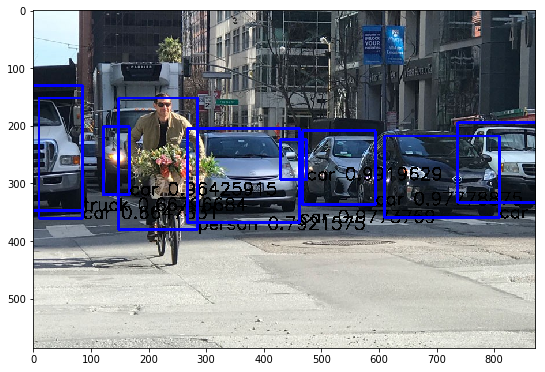

1: [truck, 0.66797]
2: [car, 0.66478]
3: [car, 0.96426]
4: [person, 0.79216]
5: [car, 0.97738]
6: [car, 0.99196]
7: [car, 0.97779]
8: [car, 0.99004]
9: [car, 0.88215]


In [26]:
image = skil.utils.yolo.annotate_image(cv2.imread("images/img-5.jpg"), detections)

cv2.imwrite('images/annotated.jpg', image)

plt.figure(figsize=(9,9))
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.show()
image.shape

for k, detection in enumerate(detections['objects']):
    predicted = detection['predictedClasses'][0]
    confidence = detection['confidences'][0]
    
    print('{}: [{}, {:.5}]'.format(k+1, predicted, confidence))